# **LIBRARIES**

The first attempt tries to use Inception for TL with no other fancy things. 
MAYBE having a "mix" of receptive fields like inception does is good.  

In [1]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()


2022-11-15 19:33:38.002009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 19:33:38.002981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 19:33:38.165222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 19:33:38.166182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 19:33:38.167009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

### Suppress warnings

In [4]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**


RGB images of 96x96 pixels.


In [5]:
def genAugmLayer(seed): 
    return tf.keras.Sequential([
     tfkl.RandomFlip("horizontal_and_vertical"),
     tfkl.RandomRotation(0.5),
     tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=seed) ])

***SELECTIVE AUGMENTATION DONE TWO TIMES TO FEED THE NN MORE SAMPLES FROM CLASSES 1 AND 6 (~ 400 PER CLASS)***


In [6]:
imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    '../input/correctedbal',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.2,
    seed=seed,
)

data_augmentation1 = genAugmLayer(17) 
dataAugmImbal = imbalClasses.map(lambda x , y : (data_augmentation1(x), y)) 
data_augmentation2 = genAugmLayer(271) 
dataAugmImbal = dataAugmImbal.concatenate(imbalClasses.map(lambda x , y : (data_augmentation2(x), y))) #double samples of classes 1 and 6 

Found 414 files belonging to 8 classes.
Using 332 files for training.


***UNIVERSAL AUGMENTATION***

In [7]:
datapath = '../input/annhw1/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)


#-------------WEIGHTS ----------------------------------
labels = np.concatenate([y for x, y in training_set], axis=0) 
class_weights = class_weight.compute_class_weight(class_weight='balanced' ,classes = [i for i in range(8)] , y = np.argmax(labels, axis=-1) ) 
weights = dict(enumerate(class_weights)) 
print(weights)
#-------------------------------------------------------



Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


2022-11-15 19:33:44.219950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


{0: 2.393581081081081, 1: 0.8296252927400468, 2: 0.8923173803526449, 3: 0.843452380952381, 4: 0.8162442396313364, 5: 2.012784090909091, 6: 0.8032879818594104, 7: 0.9060102301790282}


***RESCALING***

In [8]:
data_augmentation = genAugmLayer(89)
training_set = training_set.concatenate(training_set.map(lambda x , y : (data_augmentation(x), y)) ) #total augm
training_set = training_set.concatenate(dataAugmImbal)
#training_set = training_set.concatenate(imbalClasses) #OVERSAMPLING classes 1 and 6 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Transfer Learning**

In [10]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 90 #to be defined 

In [11]:
training_set = training_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x), y))
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x),y))

In [12]:
#ARCHITECTURE
with mirrored_strategy.scope():
    supernet = tf.keras.applications.inception_v3.InceptionV3( include_top=False, weights='imagenet')
    supernet.trainable = True
    input_layer = tfkl.Input(input_shape)
    x = tfkl.Resizing(height = 299, width = 299, interpolation = 'bicubic' )(input_layer)
    x = supernet(x)
    x = tfkl.GlobalAveragePooling2D()(x) 
    x = tfkl.Dropout(rate=0.3)(x)
    x = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed),  activation='relu')(x)
    x = tfkl.Dropout(rate=0.3)(x)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)
        
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

87924736/87910968 [==============================] - 1s 0us/step


In [13]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    '''
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)
    now = datetime.now().strftime('%b%d_%H-%M-%S')
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    '''
    callbacks = []
    
    '''
    # Model checkpoint
      # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
          
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
      
    callbacks.append(ckpt_callback)
    '''
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) #tuning point
    callbacks.append(es_callback)
    return callbacks

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Dense3 (Dense)               (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [15]:
#WEIGHTS RESTORING WHEN CRASHES 
#model.restore("./experiments/myModel_TESTING_Nov14_10-17-04")

In [16]:

for i, layer in enumerate(model.get_layer('inception_v3').layers[:-1]):
    layer.trainable=False

for i, layer in enumerate(model.get_layer('inception_v3').layers[:15]):
    layer.trainable=True
    
for i, layer in enumerate(model.get_layer('inception_v3').layers[-15:-1]):
    layer.trainable = True

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Dense3 (Dense)               (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [17]:
callbacks = create_folders_and_callbacks(model_name='myModel_TESTING')

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks,
    batch_size = 256
    #,class_weight = weights 
).history

2022-11-15 19:33:57.783018: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/90


2022-11-15 19:34:56.152733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 197 of 1000
2022-11-15 19:34:56.293514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-15 19:34:57.719358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-11-15 19:34:58.150625: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - ETA: 0s - loss: 1.5953 - accuracy: 0.4090

2022-11-15 19:36:50.706215: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



200/200 [==============================] - 182s 552ms/step - loss: 1.5953 - accuracy: 0.4090 - val_loss: 4.3521 - val_accuracy: 0.2415
Epoch 2/90
200/200 [==============================] - 99s 492ms/step - loss: 1.3395 - accuracy: 0.5190 - val_loss: 4.1505 - val_accuracy: 0.3517
Epoch 3/90
200/200 [==============================] - 99s 493ms/step - loss: 1.1323 - accuracy: 0.6008 - val_loss: 2.0894 - val_accuracy: 0.4831
Epoch 4/90
200/200 [==============================] - 98s 489ms/step - loss: 0.9529 - accuracy: 0.6691 - val_loss: 5.9032 - val_accuracy: 0.1723
Epoch 5/90
200/200 [==============================] - 98s 488ms/step - loss: 0.8225 - accuracy: 0.7187 - val_loss: 3.6163 - val_accuracy: 0.3616
Epoch 6/90
200/200 [==============================] - 97s 487ms/step - loss: 0.7084 - accuracy: 0.7541 - val_loss: 2.4174 - val_accuracy: 0.3489
Epoch 7/90
200/200 [==============================] - 99s 493ms/step - loss: 0.6095 - accuracy: 0.7858 - val_loss: 2.1719 - val_accuracy: 0.

In [18]:
final_time = datetime.now()
print("Training took %s" % (final_time - initial_time))


Training took 2:29:53.286156


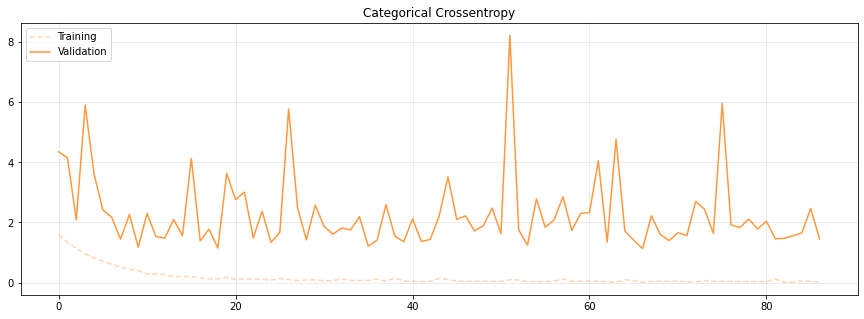

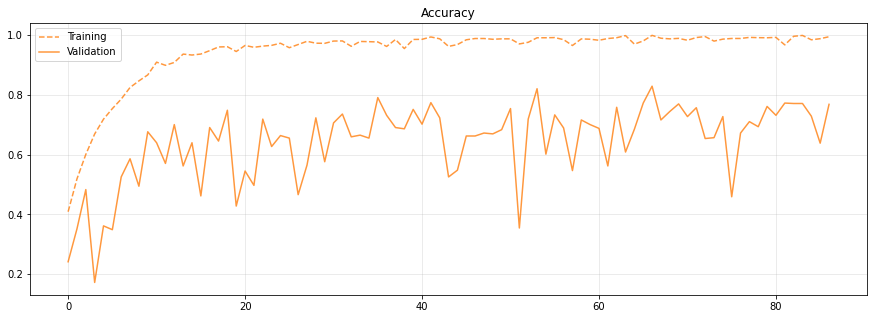

In [19]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [20]:
model.save("models/myModel")

2022-11-15 22:04:06.130714: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-11-15 22:04:39.119711: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



23/23 [==============================] - 2s 93ms/step - loss: 1.1363 - accuracy: 0.8277
{'loss': 1.1363028287887573, 'accuracy': 0.8276836276054382}


2022-11-15 22:04:41.573196: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Accuracy: 0.8277
Precision: 0.8181
Recall: 0.8016
F1: 0.8055
F1 (per class):
[0.49275362 0.83870968 0.87068966 0.83937824 0.80365297 0.89411765
 0.93684211 0.76777251]
WORST CLASS: Species: 1


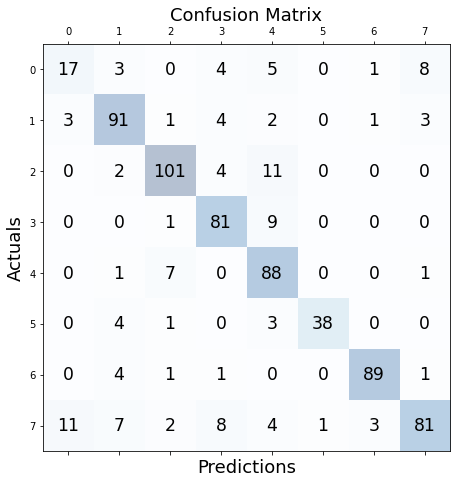

In [21]:
#model = tf.keras.models.load_model("models/myModel_AUGMENTEDDATA_WEIGHTEDCLASSES")
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()